## Implementing Auto-ARIMA for Bitcoin Closing Price Analysis

In this model, I will use Auto-ARIMA to predict the closing prices of Bitcoin from January 1st, 2017 to December 28th, 2020. 

ARIMA is a popular statistical method for time series analysis. It stands for Auto-Regressive Integrated Moving Averages, and it works on the following assumptions:

- The data series is stationary, meaning that the mean and the variance should not change with time. A series can be made stationary by using log transformation or differencing the series. This uses the "Integrated (I)" concept, denoted by 'd' in time series.
- The data provided as input must be a univariate series, since arima uses the past values to predict the future values. This means that only one variable is changing over time, as opposed to multiple variables

ARIMA has three parts: AR (Auto-Regressive), I (Integrated) and MA (Moving Average)

- AR refers to the past values used for forecasting the next value. The AR term is defined by the parameter ‘p’ in ARIMA. The value of ‘p’ is determined using the PACF plot. We will not be using the PACF plot because Auto-ARIMA does it for us, which is convenient.

- MA is used to defines number of past forecast errors used to predict the future values. The parameter ‘q’ in ARIMA represents the MA term. An ACF plot is used to identify the correct ‘q’ value, but similar to the PACF plot, we will not be using it because Auto-ARIMA has it covered.

- Integrated, or Order of Differencing (used as 'd') specifies the number of times the differencing operation is performed on series to make it stationary. Test like ADF (Augmented Dicky-Fuller) and KPSS (Kwiatkowski–Phillips–Schmidt–Shin) can be used to determine whether the series is stationary and help in identifying the d value. They are used to test a null hypothesis that an observable time series is stationary around a deterministic trend against the alternative of a unit root.

I will be using Auto-ARIMA today, which helps us find the best combination of p, d, and q that provides the least error. It is typically a tedious process which requires much statistical expertise and time, so we will write a 'grid search' algorithm using Auto ARIMA in Python to test all possible combinations, and which finds the best combination.

Given the explanation of Auto ARIMA, it is now implemented to predict for Bitcoin price between January 1st, 2017 to December 28th, 2020. I will use Pandas, NumPy, Matplotlib, Plotly, Scikit-learn, Statsmodels, and some additional Python code.

I will first import the the libraries needed, as well as the .csv file (from Yahoo Finance). Then I will display a brief header of the data as well as a plot visualization of the entire dataset for daily closing prices (at 11:59pm) that will be used.

In [27]:
import warnings
warnings.filterwarnings('ignore')

#data manipulation and treatment
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

#plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
!pip install plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#scikit-learn for modelling
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error,mean_squared_log_error

#statistics
import statsmodels.api as sm
from statsmodels.tsa.api import Holt,SimpleExpSmoothing,ExponentialSmoothing
from pmdarima import auto_arima

In [28]:
df = pd.read_csv('BTC-USD (2017).csv', sep=",")
df.head()
df['Date'] =  pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']
df = df.drop('Date',axis=1)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008
2017-01-06,1014.239990,1046.810059,883.943970,902.200989,902.200989,351876000


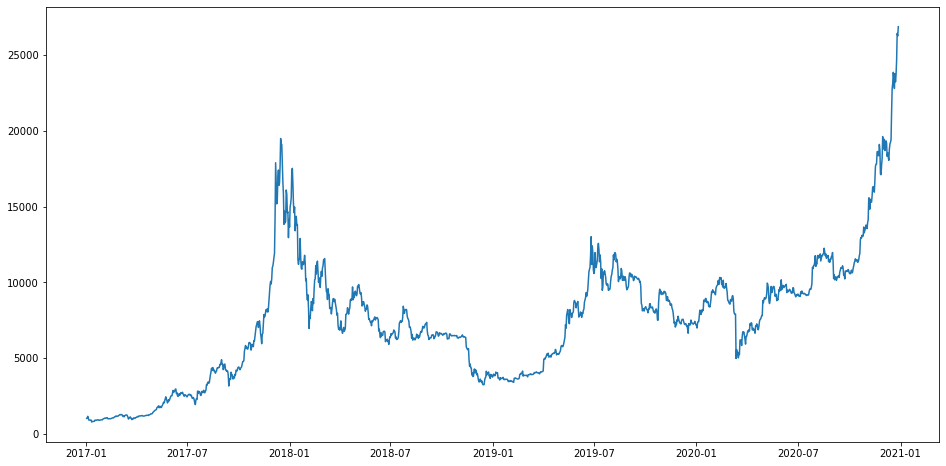

In [34]:
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise/residuals.

These components are defined as follows:

- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise/Residuals: The random variation in the series.

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

ADF (Augmented Dickey-Fuller) Test

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

So let's check for stationarity:

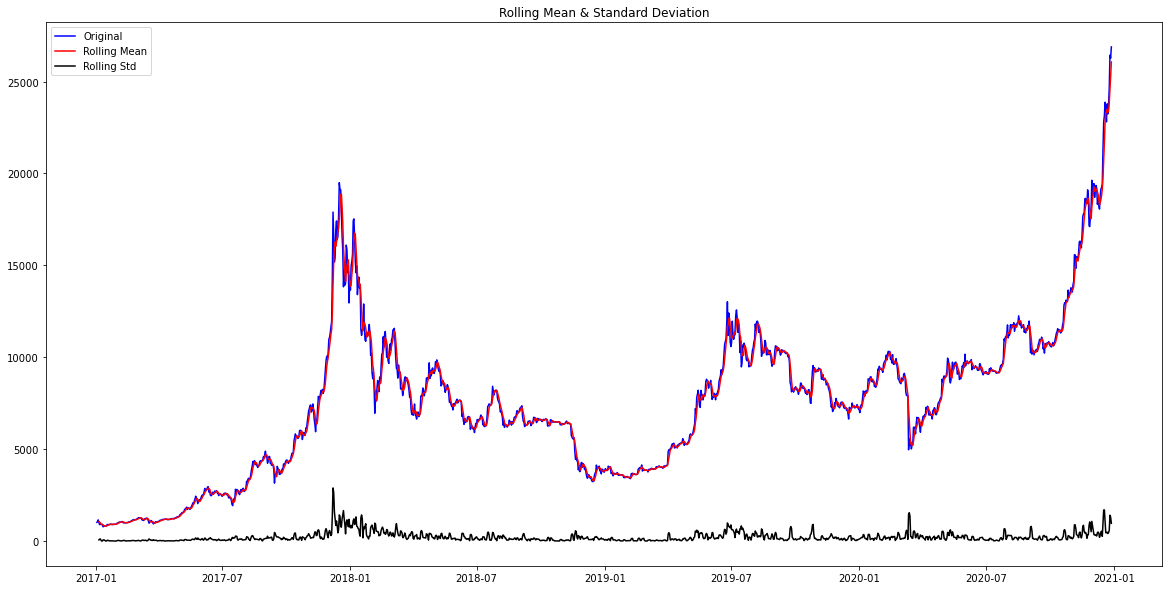

Results of Dickey-Fuller Test:
Test Statistic                    0.237979
p-value                           0.974313
#Lags Used                       21.000000
Number of Observations Used    1435.000000
Critical Value (1%)              -3.434915
Critical Value (5%)              -2.863556
Critical Value (10%)             -2.567843
dtype: float64
result : time series is not stationary


In [21]:
# Checking Stationarity - Dicky Fuller Test
from statsmodels.tsa.stattools import adfuller 
def test_stationarity(timeseries):
    
    #Determining rolling statistics
    rolmean = timeseries.rolling(4).mean() # around 4 weeks on each month
    rolstd = timeseries.rolling(4).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    if dfoutput['p-value'] < 0.05:
        print('result : time series is stationary')
    else : print('result : time series is not stationary')
        
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(df['Close'])

The p-value obtained is greater than the significance level of 0.05, and the ADF test statistic is greater than all critical values found, therefore, we do not reject the null hypothesis. This proves that the time series is non-stationary. Hence, we would need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

Let's check for the four components now: Level, Trend, Seasonality, and Noise/Residuals

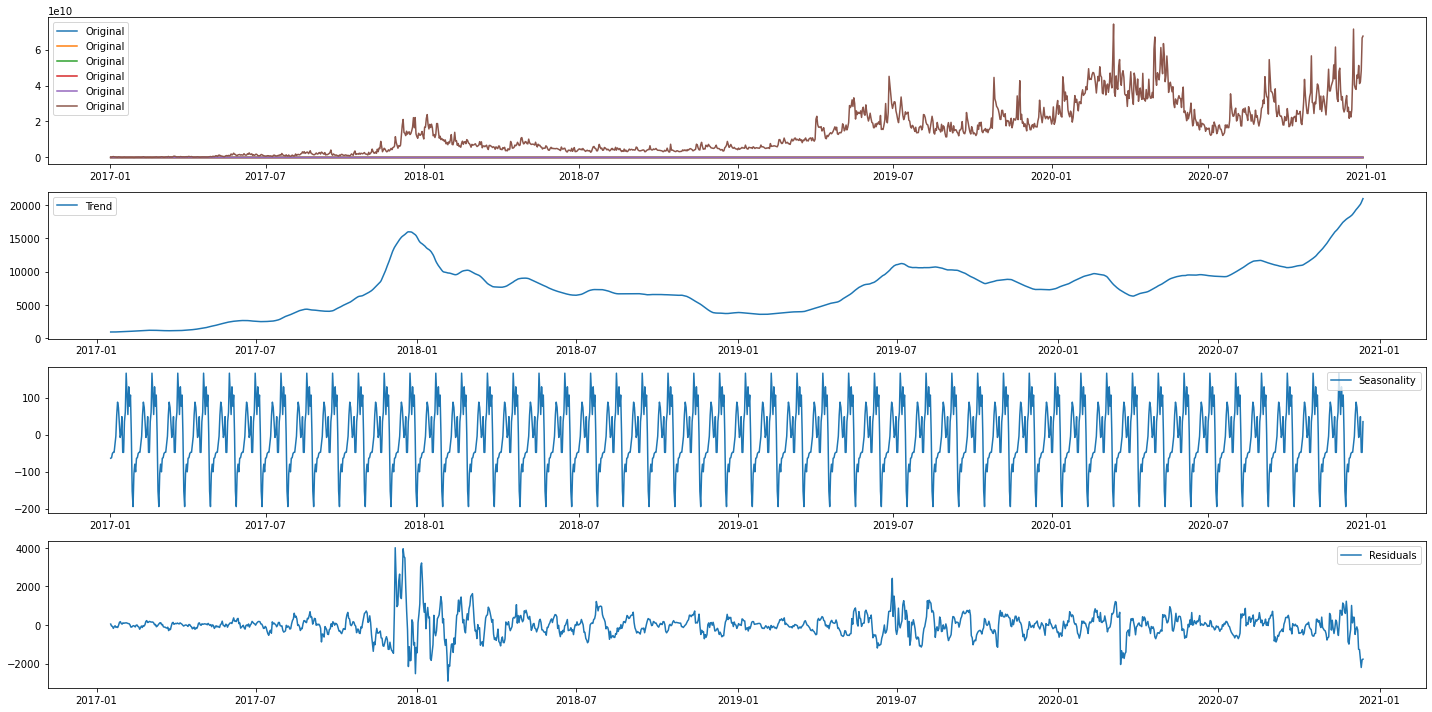

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose 
tempdf = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
decomposition = seasonal_decompose(tempdf, freq=30)

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid

plt.subplot(411) 
plt.plot(df, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

Now we create an Auto ARIMA model and we will train it and get p, d and q for ARIMA model without even needing to plot ACF and PACF graphs by doing a 'grid search' algorithm across all possible combinations.

We are trying with p, d, q values that range from 1 to 3 (1st to 3rd order AR/I/MA models).

In [31]:
data = df.sort_index(ascending=True, axis=0)

model_train = df[:1061]
valid = df[1061:]
y_pred=valid.copy()

model_scores_r2=[]
model_scores_mse=[]
model_scores_rmse=[]
model_scores_mae=[]
model_scores_rmsle=[]
model_arima= auto_arima(model_train["Close"],trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
              suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(model_train["Close"])

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15576.206, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15576.188, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15577.200, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15578.927, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15576.300, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15572.852, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15574.662, Time=0.66 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15576.173, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=15577.365, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15574.663, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15576.689, Time=1.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=15561.748, Time=2.01 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=15579.328, Time=0.15 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=15575.863, Time=0.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=15561.833, Time=1.92

ARIMA(order=(2, 1, 3), scoring_args={}, suppress_warnings=True)

The result (2, 1, 3) means that it is an AR(2) + MA(3) model, given that the series has been differentiated once (given by the 1) to achieve stationarity.

Using the trained model built above, I can end up forecasting the closing prices. The R-squared/MSE/RMSE/etc. are all to measure the degree of fit for the prediction to the actual closing price.

In [32]:
prediction_arima=model_arima.predict(len(valid))
y_pred["ARIMA Model Prediction"]=prediction_arima

r2_arima= r2_score(y_pred["Close"],y_pred["ARIMA Model Prediction"])
mse_arima= mean_squared_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
rmse_arima=np.sqrt(mean_squared_error(y_pred["Close"],y_pred["ARIMA Model Prediction"]))
mae_arima=mean_absolute_error(y_pred["Close"],y_pred["ARIMA Model Prediction"])
rmsle_arima = np.sqrt(mean_squared_log_error(y_pred["Close"],y_pred["ARIMA Model Prediction"]))

model_scores_r2.append(r2_arima)
model_scores_mse.append(mse_arima)
model_scores_rmse.append(rmse_arima)
model_scores_mae.append(mae_arima)
model_scores_rmsle.append(rmsle_arima)

print("R Square Score ARIMA: ",r2_arima)
print("Mean Square Error ARIMA: ",mse_arima)
print("Root Mean Square Error ARIMA: ",rmse_arima)
print("Mean Absoulute Error ARIMA: ",mae_arima)
print("Root Mean Squared Logarithmic Error ARIMA: ", rmsle_arima)

R Square Score ARIMA:  -0.43609024834910093
Mean Square Error ARIMA:  22713333.51627329
Root Mean Square Error ARIMA:  4765.850765212155
Mean Absoulute Error ARIMA:  3151.0962925242056
Root Mean Squared Logarithmic Error ARIMA:  0.39320482665127693


In [33]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=model_train.index, y=model_train["Close"], mode='lines',name="Train Data for Stock Prices"))

fig.add_trace(go.Scatter(x=valid.index, y=valid["Close"], mode='lines',name="Validation Data for Stock Prices",))

fig.add_trace(go.Scatter(x=valid.index, y=y_pred["ARIMA Model Prediction"], mode='lines',name="Prediction for Stock Prices",))

fig.update_layout(title="ARIMA",xaxis_title="Date",yaxis_title="Close",legend=dict(x=0,y=1,traceorder="normal"),font=dict(size=12))
fig.show()

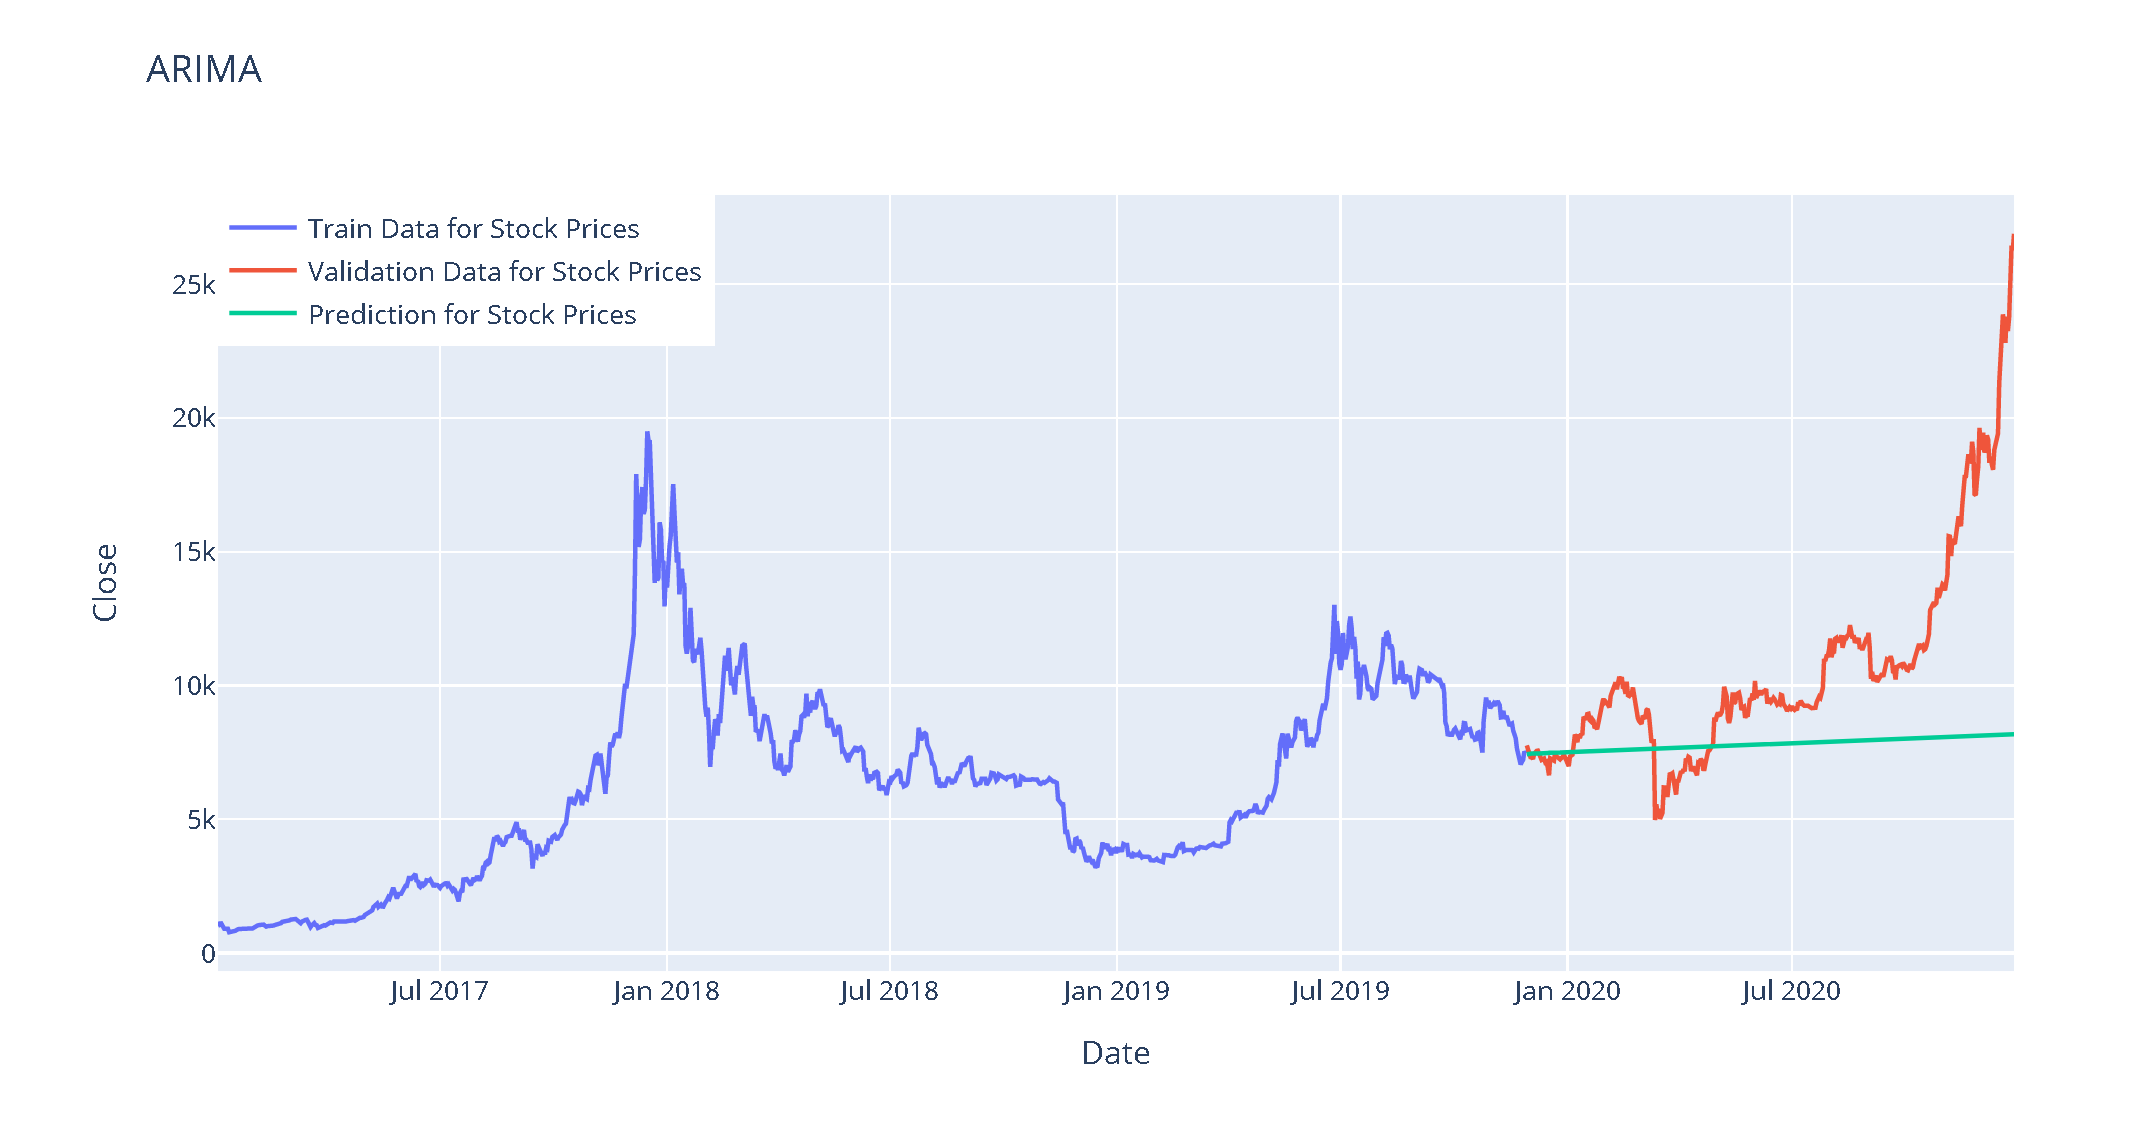

Because an Auto-ARIMA model uses past data to find a pattern in time series, similar to Prophet or LSTM, it shows evidence that stock prices are not purely determined by past prices. It is evident that the model has captured an increasing trend in the series, yet it does not match the actual price at all.

In the basic ARIMA model, we need to perform differencing and plot ACF and PACF graphs to determine these values which are time-consuming. Auto-ARIMA allows us to skip these tedious tasks, yet it is not very intuitive when you try to completely understand the statistical techniques used and implemented.

If this generates further interest, you would most likely learn it in AMS 316 (Time Series Analysis) through delving into AR, I, and MA individually. The course covers this material more in-depth.